## What is this?
Here I try to have 2 input sequences to LSTM

In [54]:
import sys
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Merge
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.utils.visualize_util import plot
from matplotlib.pyplot import show, plot
import pandas as pd
import numpy as np
import math
import random
random.seed(0)

model_name = "lstm_merge"

def weights_dir(model_version):
    return "{0}/Desktop/{1}-{2}".format(os.environ['HOME'], model_name, model_version)

def best_weights_path(model_version):
    files = os.listdir(weights_dir(model_version))
    files.sort()
    return "{0}/{1}".format(weights_dir(model_version), files[0])

def default_callback_list(model_version):
    os.makedirs(weights_dir(model_version), exist_ok=True)
    filepath = weights_dir(model_version) + "/{loss:.4f}"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    return [checkpoint]


## Load data

In [35]:
def loadData(file):
    df = pd.read_csv("../../dont_remove_data/{0}".format(file), header=None, parse_dates=["date"], names=["date", "price"], usecols=[0, 1])
    df["price"] = df["price"].astype('float32')
    df["price"] = df["price"].apply(lambda x: x / 10000)
    return df


In [45]:
# name column to merge
sony_prices = loadData("sony.csv")
sony_prices.columns = ['date', 'sony']

nikkei_prices = loadData("nikkei.csv")
nikkei_prices.columns = ['date', 'nikkei']

# merge
prices = pd.merge(sony_prices, nikkei_prices, on='date')
print(prices.head())
print("prices.shape", prices.shape)

        date   sony  nikkei
0 2007-01-04  0.514   1.735
1 2007-01-05  0.520   1.731
2 2007-01-09  0.540   1.700
3 2007-01-10  0.544   1.723
4 2007-01-11  0.545   1.698
prices.shape (2204, 3)


In [71]:
nb_prev = 200 # use nb_prev size data as input

def inputData(prices):
    X = []
    Y = []
    for i in range(len(prices)-nb_prev):
        X.append(prices.iloc[i:i+nb_prev].as_matrix())
        mixed_Y_i = np.array([prices.iloc[i+nb_prev], 1 if prices.iloc[i+nb_prev] - prices.iloc[i+nb_prev - 1] > 0 else 0])
        Y.append(mixed_Y_i)
    X = np.array(X).reshape(-1, nb_prev, 1)
    Y = np.array(Y)
    
    test_size = 0.1
    nb_train = int(round(len(X) * (1 - test_size)))
    X_train, X_test = X[:nb_train], X[nb_train:]
    Y_train, Y_test = Y[:nb_train], Y[nb_train:]    
    return X_train, Y_train, X_test, Y_test

In [72]:
X_nikkei_train, Y_nikkei_train, X_nikkei_test, Y_nikkei_test = inputData(prices['nikkei'])
X_sony_train, Y_sony_train, X_sony_test, Y_sony_test = inputData(prices['sony'])

print("nikkei", X_nikkei_train.shape, Y_nikkei_train.shape)
print("sony", X_sony_train.shape, Y_sony_train.shape)



nikkei (1804, 200, 1) (1804, 2)
sony (1804, 200, 1) (1804, 2)


## Model
https://keras.io/getting-started/sequential-model-guide/
    
    

In [73]:
encoder_a = Sequential()
encoder_a.add(LSTM(300, input_shape=(nb_prev, 1)))

encoder_b = Sequential()
encoder_b.add(LSTM(300, input_shape=(nb_prev, 1)))

decoder = Sequential()
decoder.add(Merge([encoder_a, encoder_b], mode='concat'))
decoder.add(Dense(2))  
decoder.add(Activation("linear"))  
decoder.compile(loss="mean_squared_error", optimizer="adam")

#decoder.compile(loss='categorical_crossentropy',
#                optimizer='rmsprop',
#                metrics=['accuracy'])
print(decoder.summary)


<bound method Container.summary of <keras.models.Sequential object at 0x11d13bcf8>>


In [75]:
model_version = 3
decoder.fit([X_sony_train, X_nikkei_train], Y_nikkei_train,
            batch_size=600, nb_epoch=20, validation_split=0.05, callbacks=default_callback_list(model_version))

    

Train on 1713 samples, validate on 91 samples
Epoch 1/20
1713/1713 [==============================] - 107s - loss: 0.1747 - val_loss: 0.2948
Epoch 2/20
1713/1713 [==============================] - 103s - loss: 0.1529 - val_loss: 0.1845
Epoch 3/20
1713/1713 [==============================] - 118s - loss: 0.1389 - val_loss: 0.1543
Epoch 4/20
1713/1713 [==============================] - 115s - loss: 0.1396 - val_loss: 0.1779
Epoch 5/20
1713/1713 [==============================] - 109s - loss: 0.1345 - val_loss: 0.1557
Epoch 6/20
1713/1713 [==============================] - 103s - loss: 0.1330 - val_loss: 0.1380
Epoch 7/20
1713/1713 [==============================] - 104s - loss: 0.1302 - val_loss: 0.1413
Epoch 8/20
1713/1713 [==============================] - 102s - loss: 0.1297 - val_loss: 0.1386
Epoch 9/20
1713/1713 [==============================] - 100s - loss: 0.1283 - val_loss: 0.1266
Epoch 10/20
1713/1713 [==============================] - 98s - loss: 0.1268 - val_loss: 0.1261
Epoc

In [68]:
print(best_weights_path(model_version))
decoder.load_weights(best_weights_path(model_version))   
predicted = decoder.predict([X_sony_test, X_nikkei_test])
print(predicted.shape)


/Users/higepon/Desktop/lstm_merge-2/0.1426
(200, 2)


In [69]:
prices_prediction = predicted[:,0]
up_down_prediction = predicted[:,1]
print(up_down_prediction)

[ 0.58680332  0.5873124   0.58775276  0.58776522  0.58744925  0.58701074
  0.58696932  0.58687514  0.58732933  0.58825225  0.58901489  0.58925974
  0.58962756  0.58990246  0.59050304  0.59050059  0.59010184  0.590455
  0.59089959  0.59079462  0.59082538  0.59134477  0.5915252   0.59174711
  0.59197199  0.59239161  0.59298068  0.59336603  0.59397954  0.59440559
  0.59461647  0.59450072  0.59396571  0.59381664  0.59425485  0.59465623
  0.59502256  0.59528202  0.59614891  0.59611249  0.59651726  0.59611028
  0.59562695  0.59583271  0.59575963  0.59640223  0.59628135  0.59624869
  0.59616226  0.59607303  0.59617478  0.59599686  0.59591931  0.59602493
  0.5961867   0.59646529  0.59669733  0.59679723  0.59709811  0.5973416
  0.59741211  0.59741819  0.59759551  0.59795278  0.59796792  0.59748399
  0.597637    0.5978083   0.59826046  0.59824544  0.59850019  0.59806377
  0.59724486  0.5965963   0.59665358  0.59703296  0.59747332  0.59837699
  0.59833443  0.59732413  0.59652323  0.59602821  0.59

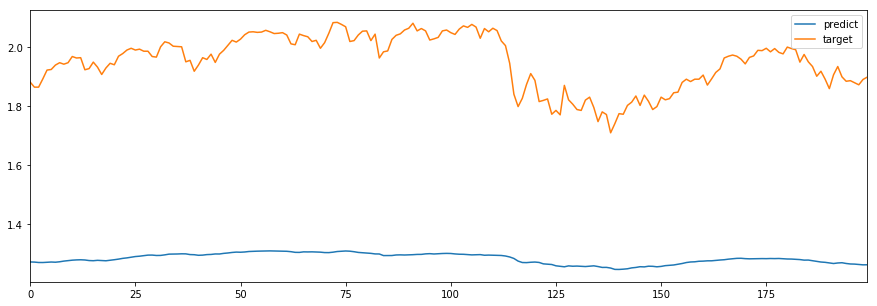

In [70]:
dataf =  pd.DataFrame(prices_prediction)
dataf.columns = ["predict"]
dataf["target"] = Y_nikkei_test[:,0]
dataf.plot(figsize=(15, 5))
show()    